In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os, random
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Reshape
from keras.optimizers import RMSprop
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# from itertools import imap as map

%matplotlib inline

TABLE_FILE = "../../data/image_pairs_filtered.csv"
IMAGES_DIR = "../../data/ssd-images/"

In [3]:
def is_valid_pair(row):
    return os.path.exists(IMAGES_DIR + row['id_0'] + '.jpg') and os.path.exists(IMAGES_DIR + row['id_1'] + '.jpg')

csv_data = pd.read_csv(TABLE_FILE, sep=';')

print(csv_data.shape)
print(csv_data.columns)

if not os.path.exists('./pair_data.pkl'):
    csv_data['is_valid'] = csv_data.apply(is_valid_pair, axis=1)
    valid_data = csv_data[csv_data['is_valid'] == True].dropna()
    valid_data.to_pickle('./pair_data.pkl')
    csv_data = valid_data
else:
    csv_data = pd.read_pickle('./pair_data.pkl')

print('Valid data:')
print(csv_data.shape)
print(csv_data.columns)

(158034, 6)
Index(['id_0', 'img_0', 'id_1', 'img_1', 'match', 'job'], dtype='object')
Valid data:
(125367, 7)
Index(['id_0', 'img_0', 'id_1', 'img_1', 'match', 'job', 'is_valid'], dtype='object')


In [4]:
print(csv_data.shape)
print(csv_data.columns)
len_true = len(csv_data[csv_data['match'] == True])
len_false = len(csv_data[csv_data['match'] == False])
print( len_true, len_false)
print( len_true / (len_true + len_false) )
csv_data.loc[1]['id_0']

(125367, 7)
Index(['id_0', 'img_0', 'id_1', 'img_1', 'match', 'job', 'is_valid'], dtype='object')
61405 63962
0.4898019414997567


'd8538bc1d41a16a4c9b346abeb48adb702444ecc'

In [5]:
def data_batch(dframe, batch_size):
#     return dframe[dframe['match'] == True][:batch_size]
    true_sample = dframe[dframe['match'] == True].sample(n=batch_size // 2)
    
    false_dframe = dframe[dframe['match'] == False]
    false_sample = pd.DataFrame()
    for i,true_row in true_sample.iterrows():
        false_match = false_dframe[false_dframe['id_0'] == true_row['id_0']]
        if len(false_match) > 0 and random.random() < 0.5:
            new_row = false_match.head(1)
            false_sample = false_sample.append(new_row)
        else:
            rand_row = false_dframe.sample()
            new_row = true_row.copy()
            new_row['match'] = False
            new_row['id_1'] = rand_row['id_1'].values[0]
            new_row['img_1'] = rand_row['img_1'].values[0]
            false_sample = pd.concat([false_sample, pd.DataFrame([new_row])])

    batch = pd.concat([true_sample, false_sample]).reset_index()
    return batch.sort_values('id_0')

def data_batch_flow(dframe, batch_size):
    while True:
        yield data_batch(dframe, batch_size)

In [6]:
def id_to_img(img_id):
    try:
        path = IMAGES_DIR + img_id + ".jpg"
        return img_to_array(load_img(path))
    except Exception as e:
        return None

def row_to_img_pair(row):
    img_0 = id_to_img(row['id_0'])
    img_1 = id_to_img(row['id_1'])
    if img_0 is None or img_1 is None:
        return None, None
    target = 1 if row['match'] == True else 0
    
    return [img_0 / 255, img_1 / 255], target

def batch_to_img_pairs(dframe):
    pairs = []
    targets = []
    for index, row in dframe.iterrows():
        pair, target = row_to_img_pair(row)
        if pair is not None:
            pairs.append(pair)
            targets.append(target)
    
    return np.array(pairs), np.array(targets)

In [7]:
next(data_batch_flow(csv_data, 4))

,index,id_0,img_0,id_1,img_1,match,job,is_valid
1,134228,08bef1e23f7a7ef2a79ae31e757f1fd88a51734b,http://picscdn.redblue.de/doi/pixelboxx-mss-74...,820cdcd6abf4d991b4ec16a3759418053790446a,https://images-na.ssl-images-amazon.com/images...,True,mediamarktbe.id_matching,True
3,134228,08bef1e23f7a7ef2a79ae31e757f1fd88a51734b,http://picscdn.redblue.de/doi/pixelboxx-mss-74...,fb626c1565d7371bb61561128a4c57e47d15c20d,http://www.vandenborre.be/WEB/images/products/...,False,mediamarktbe.id_matching,True
0,39042,62febe6a0bd6fb84633efc278b5e9aef1b9847a1,http://picscdn.redblue.de/doi/pixelboxx-mss-59...,21343742abe89b70750c7db5a4383b3eb2cd9322,https://s.s-bol.com/imgbase0/imagebase3/large/...,True,mediamarktbe.all_data,True
2,39042,62febe6a0bd6fb84633efc278b5e9aef1b9847a1,http://picscdn.redblue.de/doi/pixelboxx-mss-59...,2f682cd50001e5b46ab6ebb0c1ca3982e1f31687,http://www.vandenborre.be/WEB/images/products/...,False,mediamarktbe.all_data,True


In [8]:
pair_flow = map(batch_to_img_pairs, data_batch_flow(csv_data, 32))

In [9]:
pairs, targets = next(pair_flow)
pair = pairs[0]
img_0 = pair[0]
img_1 = pair[1]
img_0[0][0] # pixel

array([1., 1., 1.], dtype=float32)

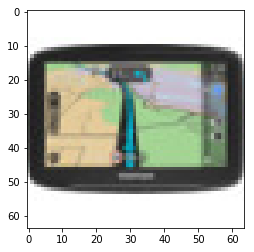

In [10]:
plt.imshow(img_0)

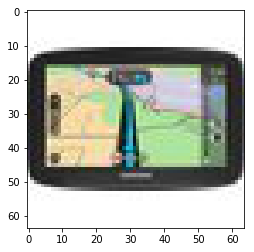

In [11]:
plt.imshow(img_1)

In [12]:
pairs.shape
print(pairs[:,1].shape)
del pair_flow

(32, 64, 64, 3)


In [13]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [14]:
# img_array to feature vector
def extraction_network(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    
    x = base_model.output
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    features = Dense(512, activation='relu', name='fc2')(x)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Model(inputs=base_model.input, outputs=features)
    model.summary()
    return model

In [15]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


input_shape = (64, 64, 3)

base_network = extraction_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

58892288/58889256 [==============================] - 46s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_poo

In [16]:
processed_a

<tf.Tensor 'model_1/fc2/Relu:0' shape=(?, 512) dtype=float32>

In [17]:
# train
tr_pair_flow = map(batch_to_img_pairs, data_batch_flow(csv_data, 32))
te_pair_flow = map(batch_to_img_pairs, data_batch_flow(csv_data, 32))

tr_pair_flow_gen = map(lambda batch: ([batch[0][:,0], batch[0][:,1]], batch[1]), tr_pair_flow)
te_pair_flow_gen = map(lambda batch: ([batch[0][:,0], batch[0][:,1]], batch[1]), te_pair_flow)


rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit_generator(
    tr_pair_flow_gen,
    steps_per_epoch=100,
    epochs=3,
    validation_data=te_pair_flow_gen,
    validation_steps=10,
)

Epoch 1/3
100/100 [==============================] - 67s 675ms/step - loss: 0.2627 - accuracy: 0.7478 - val_loss: 0.1589 - val_accuracy: 0.7750
Epoch 2/3
100/100 [==============================] - 58s 578ms/step - loss: 0.1418 - accuracy: 0.8263 - val_loss: 0.1151 - val_accuracy: 0.8688
Epoch 3/3
100/100 [==============================] - 66s 664ms/step - loss: 0.1365 - accuracy: 0.8366 - val_loss: 0.1303 - val_accuracy: 0.8500


In [18]:
# compute final accuracy on training and test sets
tr_batch, tr_y = next(tr_pair_flow_gen)
te_batch, te_y = next(te_pair_flow_gen)

y_pred = model.predict_on_batch(tr_batch)
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict(te_batch)
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 81.25%
* Accuracy on test set: 78.12%


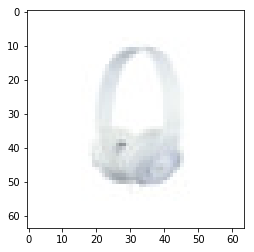

In [19]:
# 0a9a6d9e4f345d73b96bc9ab3f980f1448d3dec9 ? 0aa0bd14a908076356dc343f4c31e352b852bed5 False
# 0a9a6d9e4f345d73b96bc9ab3f980f1448d3dec9 ? d6d763d2f06f5c43ac6c645dc6c76b5194f125ec False
test_img_0 = id_to_img('0a9a6d9e4f345d73b96bc9ab3f980f1448d3dec9') / 255
test_img_1 = id_to_img('0aa0bd14a908076356dc343f4c31e352b852bed5') / 255
test_img_2 = id_to_img('d6d763d2f06f5c43ac6c645dc6c76b5194f125ec') / 255
plt.imshow(test_img_0)

In [20]:
model.predict_on_batch([np.array([test_img_0]), np.array([test_img_1])])

array([[0.93449426]], dtype=float32)

In [21]:
model.predict_on_batch([np.array([test_img_0]), np.array([test_img_2])])

array([[0.36089844]], dtype=float32)